In [1]:
#import pyscamp
from obspy import read, UTCDateTime, Stream
import os
import numpy as np
import sys
import time
from glob import glob
from MPLib import *
from GraphLib import *
from util import *

from util import get_stream_1day
from MPLib import *

#starttime=UTCDateTime(2020,2,18,0,0,0)
#endtime = starttime+86400
#trace = get_stream_1day("G12", "DPZ", starttime=starttime, endtime=endtime, fs=250.0, gain=1e18)
#print(trace)

fname_mp = "20200218000000.000000_20200218235959.996000_G12_DPZ_250Hz_win125samp_mp.npy"
fname_ind = fname_mp.replace("_mp", "_ind")

input_dir = "/home/genevieve.savard/seismo-pyscamp/data_borehole/matrix_profiles"
mp = np.load(os.path.join(input_dir, fname_mp))
ind = np.load(os.path.join(input_dir, fname_ind))

station = os.path.split(fname_mp)[1].split("_")[2]
channel = os.path.split(fname_mp)[1].split("_")[3]
print("Station %s, channel %s" % (station, channel))
starttime = UTCDateTime(os.path.split(fname_mp)[1].split("_")[0])
endtime = UTCDateTime(os.path.split(fname_mp)[1].split("_")[1])
fs = float(os.path.split(fname_mp)[1].split("_")[4].split("Hz")[0])
print("Start time %s" % starttime)
print("End time %s" % endtime)
print("Sampling rate: %s" % fs)

sublen_samp = int(os.path.split(fname_mp)[1].split("_")[5].split("win")[1].split("samp")[0])
print("sublen_samp = %d" % sublen_samp)
print("Length of MP: %d samples" % mp.shape[0])

# mpObj = MatrixProfile(mp=mp, ind=ind, trace=trace, sublen=sublen_samp)
mpObj = MatrixProfile(mp=mp, ind=ind, 
                      station=station, channel=channel, fs=fs, sublen=sublen_samp,
                      starttime=starttime, endtime=endtime)

mpObj.get_peaks()
mpObj.group_ids(tol=100)

Station G12, channel DPZ
Start time 2020-02-18T00:00:00.000000Z
End time 2020-02-18T23:59:59.996000Z
Sampling rate: 250.0
sublen_samp = 125
Length of MP: 21599876 samples


([[0,
   438,
   2800,
   172,
   496,
   1098,
   1356,
   692,
   60,
   2631,
   299,
   1553,
   2175,
   1546,
   3524,
   1957,
   900,
   1170,
   1279,
   1523,
   3491,
   2325,
   2428,
   196,
   596,
   122,
   672,
   389,
   100,
   4119,
   75,
   141,
   228,
   232,
   289,
   348,
   776,
   844,
   1033,
   1064,
   1175,
   1180,
   1382,
   1423,
   1515,
   1543,
   1612,
   1747,
   3197,
   44,
   526,
   2019,
   17,
   3699,
   3891,
   4112,
   2516,
   3120,
   393,
   77,
   173,
   264,
   1778,
   834,
   1007,
   1304,
   1375,
   1512,
   1730,
   3577,
   268,
   36,
   1784,
   257,
   2594,
   3266,
   2177,
   487,
   1138,
   519,
   256,
   992,
   7,
   263,
   720,
   1041,
   2321,
   2372,
   2496,
   2076,
   357,
   318,
   1525,
   1368,
   1353,
   208,
   1958,
   68,
   3284,
   435,
   1833,
   991,
   604,
   932,
   3397,
   25,
   420,
   12,
   428,
   859,
   2898,
   576,
   341,
   355,
   1093,
   3700,
   1116,
   10,
   607,
 

In [2]:
from IPython.display import SVG

import numpy as np
from scipy import sparse

from sknetwork.utils import edgelist2adjacency, edgelist2biadjacency
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph

# Create graph
subset = mpObj.pairs[["win_id_1", "win_id_2", "peak_cc"]]

edgelist = [tuple(x) for x in subset.to_numpy()]
adjacency = edgelist2adjacency(edgelist)

# image = svg_graph(adjacency)
# SVG(image)

In [53]:
from sknetwork.topology import connected_components

labels = connected_components(adjacency)
print(set(labels))



{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}


In [68]:
pos1 = mpObj.pairs["win_id_1"].values  
pos2 = mpObj.pairs["win_id_2"].values 
pos = np.unique(np.hstack((pos1, pos2)))

for ix in pos:
    tix = mpObj.mp_starttime + ix/mpObj.fs
    print(tix)

2020-02-18T00:00:00.500000Z
2020-02-18T00:00:00.504000Z
2020-02-18T00:00:00.508000Z
2020-02-18T00:00:00.512000Z
2020-02-18T00:00:00.516000Z
2020-02-18T00:00:00.520000Z
2020-02-18T00:00:00.524000Z
2020-02-18T00:00:00.528000Z
2020-02-18T00:00:00.532000Z
2020-02-18T00:00:00.536000Z
2020-02-18T00:00:00.540000Z
2020-02-18T00:00:00.544000Z
2020-02-18T00:00:00.548000Z
2020-02-18T00:00:00.552000Z
2020-02-18T00:00:00.556000Z
2020-02-18T00:00:00.560000Z
2020-02-18T00:00:00.564000Z
2020-02-18T00:00:00.568000Z
2020-02-18T00:00:00.572000Z
2020-02-18T00:00:00.576000Z
2020-02-18T00:00:00.580000Z
2020-02-18T00:00:00.584000Z
2020-02-18T00:00:00.588000Z
2020-02-18T00:00:00.592000Z
2020-02-18T00:00:00.596000Z
2020-02-18T00:00:00.600000Z
2020-02-18T00:00:00.604000Z
2020-02-18T00:00:00.608000Z
2020-02-18T00:00:00.612000Z
2020-02-18T00:00:00.616000Z
2020-02-18T00:00:00.620000Z
2020-02-18T00:00:00.624000Z
2020-02-18T00:00:00.628000Z
2020-02-18T00:00:00.632000Z
2020-02-18T00:00:00.636000Z
2020-02-18T00:00:00.

2020-02-18T00:00:08.372000Z
2020-02-18T00:00:08.376000Z
2020-02-18T00:00:08.380000Z
2020-02-18T00:00:08.384000Z
2020-02-18T00:00:08.388000Z
2020-02-18T00:00:08.392000Z
2020-02-18T00:00:08.396000Z
2020-02-18T00:00:08.400000Z
2020-02-18T00:00:08.404000Z
2020-02-18T00:00:08.408000Z
2020-02-18T00:00:08.412000Z
2020-02-18T00:00:08.416000Z
2020-02-18T00:00:08.420000Z
2020-02-18T00:00:08.424000Z
2020-02-18T00:00:08.428000Z
2020-02-18T00:00:08.432000Z
2020-02-18T00:00:08.436000Z
2020-02-18T00:00:08.440000Z
2020-02-18T00:00:08.444000Z
2020-02-18T00:00:08.448000Z
2020-02-18T00:00:08.452000Z
2020-02-18T00:00:08.456000Z
2020-02-18T00:00:08.460000Z
2020-02-18T00:00:08.464000Z
2020-02-18T00:00:08.468000Z
2020-02-18T00:00:08.472000Z
2020-02-18T00:00:08.476000Z
2020-02-18T00:00:08.480000Z
2020-02-18T00:00:08.484000Z
2020-02-18T00:00:08.488000Z
2020-02-18T00:00:08.492000Z
2020-02-18T00:00:08.496000Z
2020-02-18T00:00:08.500000Z
2020-02-18T00:00:08.504000Z
2020-02-18T00:00:08.508000Z
2020-02-18T00:00:08.

2020-02-18T00:00:16.612000Z
2020-02-18T00:00:16.616000Z
2020-02-18T00:00:16.620000Z
2020-02-18T00:00:16.624000Z
2020-02-18T00:00:16.628000Z
2020-02-18T00:00:16.632000Z
2020-02-18T00:00:16.636000Z
2020-02-18T00:00:16.640000Z
2020-02-18T00:00:16.644000Z
2020-02-18T00:00:16.648000Z
2020-02-18T00:00:16.652000Z
2020-02-18T00:00:16.656000Z
2020-02-18T00:00:16.660000Z
2020-02-18T00:00:16.664000Z
2020-02-18T00:00:16.668000Z
2020-02-18T00:00:16.672000Z
2020-02-18T00:00:16.676000Z
2020-02-18T00:00:16.680000Z
2020-02-18T00:00:16.684000Z
2020-02-18T00:00:16.688000Z
2020-02-18T00:00:16.692000Z
2020-02-18T00:00:16.696000Z
2020-02-18T00:00:16.700000Z
2020-02-18T00:00:16.704000Z
2020-02-18T00:00:16.708000Z
2020-02-18T00:00:16.712000Z
2020-02-18T00:00:16.716000Z
2020-02-18T00:00:16.720000Z
2020-02-18T00:00:16.724000Z
2020-02-18T00:00:16.728000Z
2020-02-18T00:00:16.732000Z
2020-02-18T00:00:16.736000Z
2020-02-18T00:00:16.740000Z
2020-02-18T00:00:16.744000Z
2020-02-18T00:00:16.748000Z
2020-02-18T00:00:16.

In [116]:
import networkx as nx

G = nx.from_scipy_sparse_matrix(adjacency)

from networkx.algorithms.components import *

#print(is_connected(G))
#print(number_connected_components(G))

groups = [G.subgraph(c).copy() for c in nx.connected_components(G)]

for i, group in enumerate(groups):
    print("Group %d: %d nodes." % (i, len(group)))
    

Group 0: 4200 nodes.
Group 1: 5 nodes.
Group 2: 24 nodes.
Group 3: 23 nodes.
Group 4: 9 nodes.
Group 5: 6 nodes.
Group 6: 2 nodes.
Group 7: 2 nodes.
Group 8: 5 nodes.
Group 9: 7 nodes.
Group 10: 2 nodes.
Group 11: 2 nodes.
Group 12: 2 nodes.
Group 13: 5 nodes.
Group 14: 2 nodes.
Group 15: 2 nodes.
Group 16: 2 nodes.
Group 17: 3 nodes.
Group 18: 2 nodes.
Group 19: 2 nodes.
Group 20: 2 nodes.
Group 21: 2 nodes.


0.634309067738
group 0
4200
0.855436058837


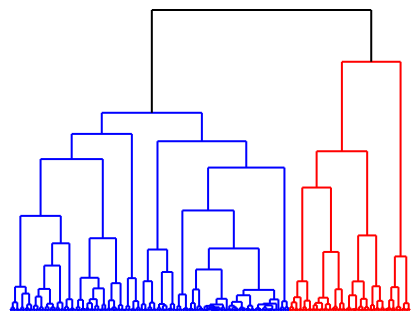

In [114]:
import networkx as nx

G = nx.from_scipy_sparse_matrix(adjacency)

from networkx.algorithms.components import *

#print(is_connected(G))
#print(number_connected_components(G))

groups = [G.subgraph(c).copy() for c in nx.connected_components(G)]

for i, group in enumerate(groups):
    print("Group %d: %d nodes." % (i, len(group)))
    print(is_connected(group))
    
    
from sknetwork.hierarchy import Paris, BiParis, cut_straight, dasgupta_score, tree_sampling_divergence

print(score)
print("group 0")
group = groups[0]
print(len(group))
tmp = nx.to_scipy_sparse_matrix(group)
paris = Paris()
dendrogram = paris.fit_transform(tmp)
score = tree_sampling_divergence(tmp, dendrogram, normalized=True)
print(score)

image = svg_dendrogram(dendrogram)
SVG(image)



group 2
24
0.730401065003


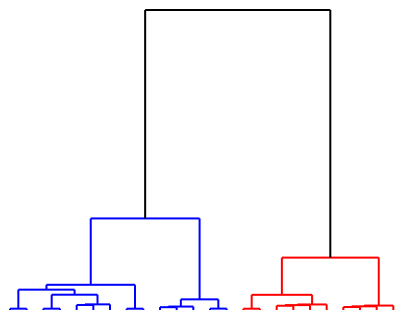

In [117]:
from sknetwork.hierarchy import tree_sampling_divergence, Paris

print("group 2")
group = groups[2]
print(len(group))
tmp = nx.to_scipy_sparse_matrix(group)
paris = Paris()
dendrogram = paris.fit_transform(tmp)
score = tree_sampling_divergence(tmp, dendrogram, normalized=True)
print(score)

image = svg_dendrogram(dendrogram)
SVG(image)


In [119]:
labels = cut_straight(dendrogram, n_clusters = 4)
print(labels)

[2 2 1 0 0 2 0 1 1 3 0 3 3 0 0 1 0 0 3 1 2 0 2 1]
